# Open PTU files
This notebook opens ".ptu" files and plot some images and graphs of an example image.

In [79]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import napari
from napari.utils import nbscreenshot

from readPTU_FLIM import PTUreader

## Set data path
Provide local path to `.ptu` image.

In [80]:
data_path = r"D:\Datasets\FLIM\ptu_files\single slice\raw_FLIM_data\single_FLIM_image.ptu"
# data_path = "C:/Users/cblei/Desktop/miniSabb_local/FLIM_file_formats/single_FLIM_image.ptu"

Turn string path into a `Path` variable (from `pathlib` library)

In [81]:
data_path = Path(data_path)
print(data_path)

D:\Datasets\FLIM\ptu_files\single slice\raw_FLIM_data\single_FLIM_image.ptu


## Opening a `.ptu` file

One can open a `.ptu` file using a custom module from this address: https://github.com/SumeetRohilla/readPTU_FLIM (we have made a local copy since the remote repository is not a python package).

In [82]:
ptu_file = PTUreader(data_path, print_header_data = False)

TCSPC Hardware: PicoHarpT3
Raw Data has been Read!



We can see some metadata by inspecting the `.head` property.

In [83]:
ptu_file.head

{'File_GUID': 40,
 'File_CreatingTime': 13301658052.442,
 '$StartedByRemoteInterface': True,
 'Measurement_SubMode': 3,
 'File_Comment': '',
 'TTResult_StopReason': 1,
 'Fast_Load_End': 0,
 'CreatorSW_Name': 'SymPhoTime 64',
 'CreatorSW_Version': '1.6',
 'CreatorSW_SVNBuild': 3224,
 'CreatorSW_Modules': 0,
 '$ReqHdr_RecordVersion': 16777728,
 '$ReqHdr_MeasurementType': 1,
 '$ReqHdr_PixelNumber_X': 512,
 '$ReqHdr_PixelNumber_Y': 512,
 '$ReqHdr_ScanningPattern': 0,
 '$ReqHdr_SpatialResolution': 0.07035765166,
 '$Filename': 'single_FLIM_image',
 '$Comment': '',
 '$Groupname': 'single_FLIM_image',
 'ImgHdr_Dimensions': 3,
 'ImgHdr_Ident': 3,
 'ImgHdr_PixX': 512,
 'ImgHdr_PixY': 512,
 'ImgHdr_PixResol': 0.07035765166,
 'ImgHdr_LineStart': 1,
 'ImgHdr_LineStop': 2,
 'ImgHdr_Frame': 3,
 'ImgHdr_BiDirect': 0,
 'ImgHdr_SinCorrection': 0,
 'Measurement_Mode': 3,
 'HW_Type': 'PicoHarp',
 'HW_SerialNo': '1020815',
 'HW_Version': '2.0',
 'HW_ExternalRefClock': False,
 'HW_Modules': 1,
 'HWModule_Ty

## Getting FLIM data
We use the `.get_flim_data_stack` method from the 'ptu_file' instance to retrieve the whole flim data in the first returned variable and the intensity image (the summed intensities over the flim dimension) in the second returned variable.

In [84]:
flim_data_stack, intensity_image = ptu_file.get_flim_data_stack()

By checking the shape, we see that we have a 4D image (x, y, channel/detector, photon counting/microtime).

In [85]:
flim_data_stack.shape

(512, 512, 2, 270)

In [86]:
intensity_image.shape

(512, 512)

## Displaying intensity image
We can display the intensity image in the jupyter notebook like this:

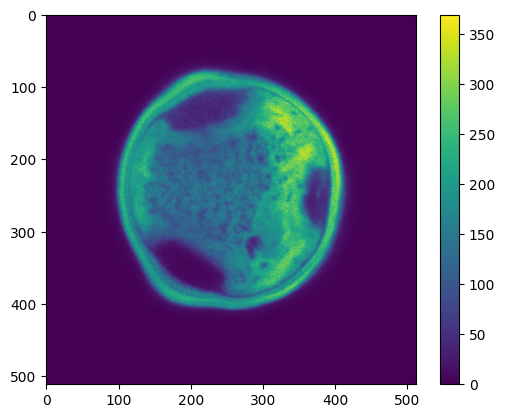

In [87]:
plt.imshow(intensity_image)
plt.colorbar()

## Displaying in napari
If we want to look at higher dimension flim data, napari may be better suited. We do a little pre-processing before adding the image to a napari viewer.

- Re-arange axes to have (x,y) by the end.

In [88]:
flim_data_stack_for_napari = np.moveaxis(flim_data_stack, [0, 1], [-2, -1])

- Get only first channel (the second channel for this image is empty)

In [89]:
flim_data_stack_for_napari = flim_data_stack_for_napari[0, :, :, :]

In [90]:
flim_data_stack_for_napari.shape

(270, 512, 512)

- Open napari viewer

In [91]:
viewer = napari.Viewer()

- Add image (time-series) to napari

In [92]:
viewer.add_image(flim_data_stack_for_napari)

<Image layer 'flim_data_stack_for_napari' at 0x16ade215790>

- Set slider to position `12`, adjust contrast and take a screenshot.

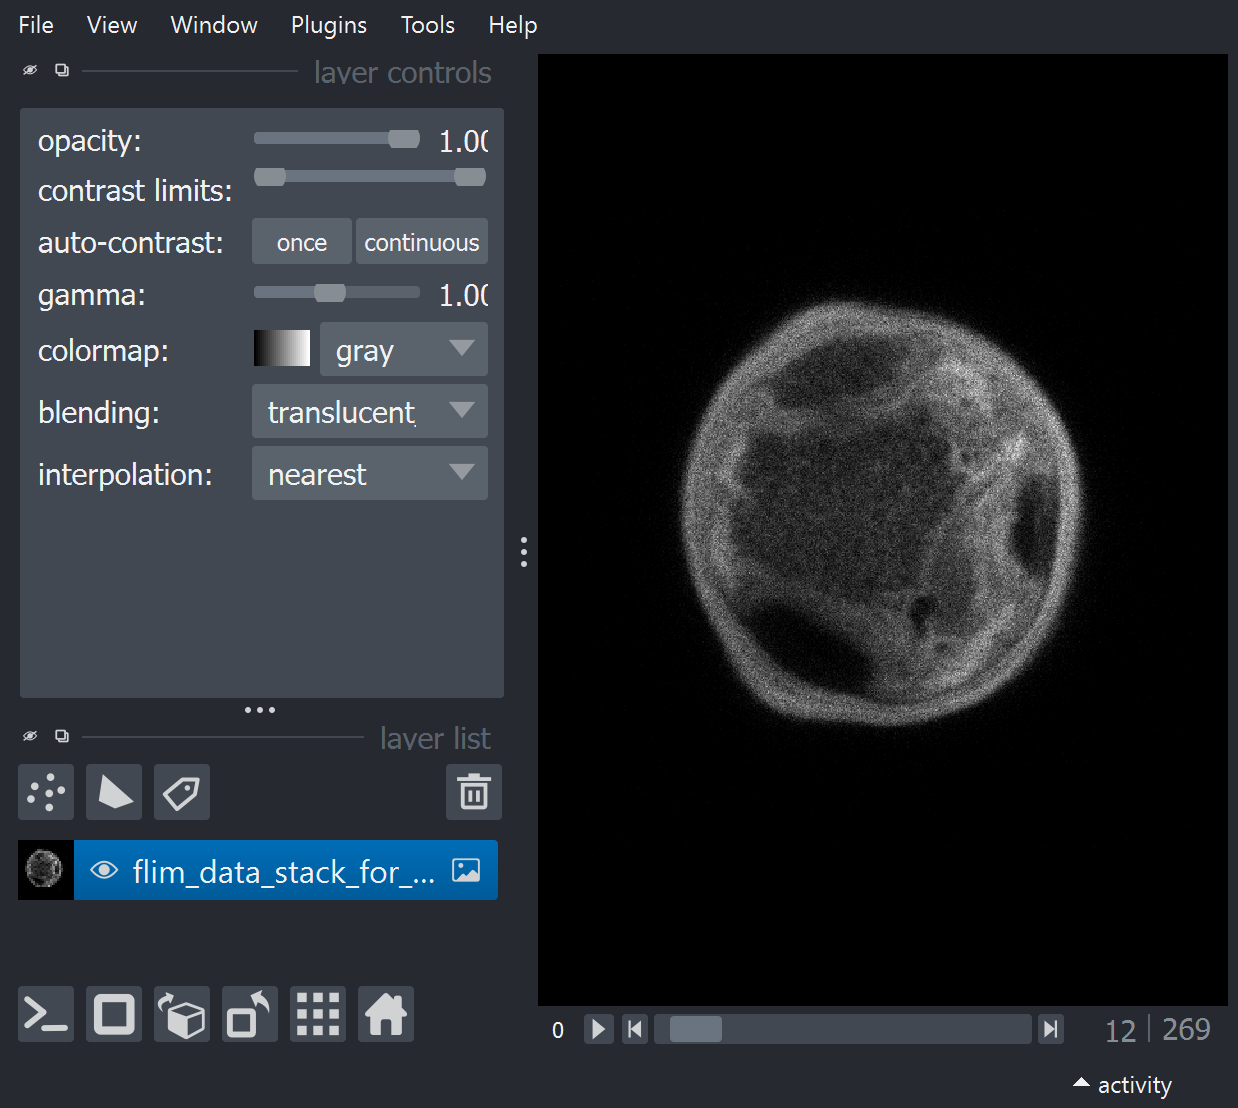

In [101]:
viewer.dims.current_step = [12, 256, 256]
viewer.layers[0].contrast_limits = [0, np.amax(flim_data_stack_for_napari)]
nbscreenshot(viewer)

## Plotting one pixel over time

We choose one pixel and get its signal over time:

In [94]:
pixel = flim_data_stack_for_napari[:,150,150]

By providing the laser frequency used during image acquisition, we calculate the laser period in nanoseconds:

In [95]:
laser_frequency = 40 # MHz
laser_time_window = 1 / (laser_frequency * 10**6)
laser_time_window_ns = laser_time_window * 10**9
laser_time_window_ns

25.0

Assuming we have a constant sampling frequency, we can calculate the time step:

In [96]:
total_time_points = flim_data_stack_for_napari.shape[0]
total_time_points

270

In [97]:
time_step = laser_time_window_ns / total_time_points # ns
time_step

0.09259259259259259

And build a time array:

In [98]:
time_array = np.arange(0, total_time_points) * time_step

Finally, we plot the pixel intensities over time with `matplotlib`.

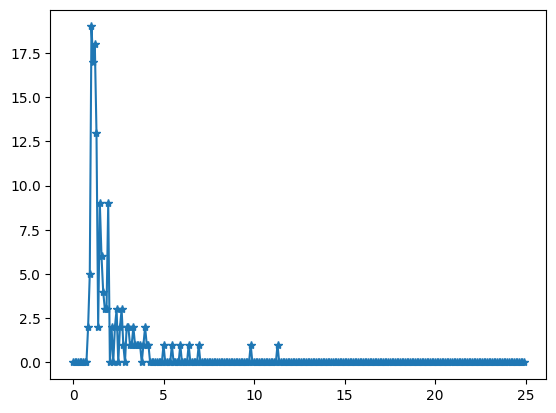

In [99]:
plt.plot(time_array, pixel, '-*')

We can choose other plot types, like bars.

<BarContainer object of 270 artists>

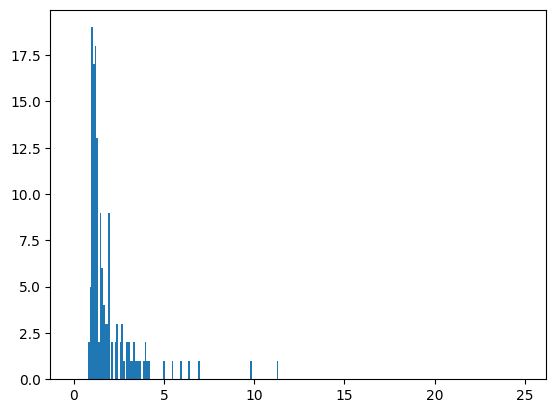

In [100]:
plt.bar(time_array, pixel, width = time_step)